In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [2]:
from pandas_datareader import data as pdr
import yfinance as yf
yf.pdr_override()
df = pdr.get_data_yahoo("LT.NS", start="2022-01-03").reset_index()
df.to_csv('LT.csv',index=False)
df.head()

[*********************100%***********************]  1 of 1 completed


,Date,Open,High,Low,Close,Adj Close,Volume
0,2022-01-03,1895.000000,1937.449951,1893.650024,1922.849976,1894.265625,1906676
1,2022-01-04,1922.849976,1943.000000,1914.550049,1937.550049,1908.747192,1643920
2,2022-01-05,1940.699951,1951.000000,1927.650024,1948.599976,1919.632812,1711667
3,2022-01-06,1944.500000,1953.000000,1919.599976,1924.500000,1895.891113,1372015
4,2022-01-07,1929.050049,1934.949951,1897.150024,1904.900024,1876.582520,1447123


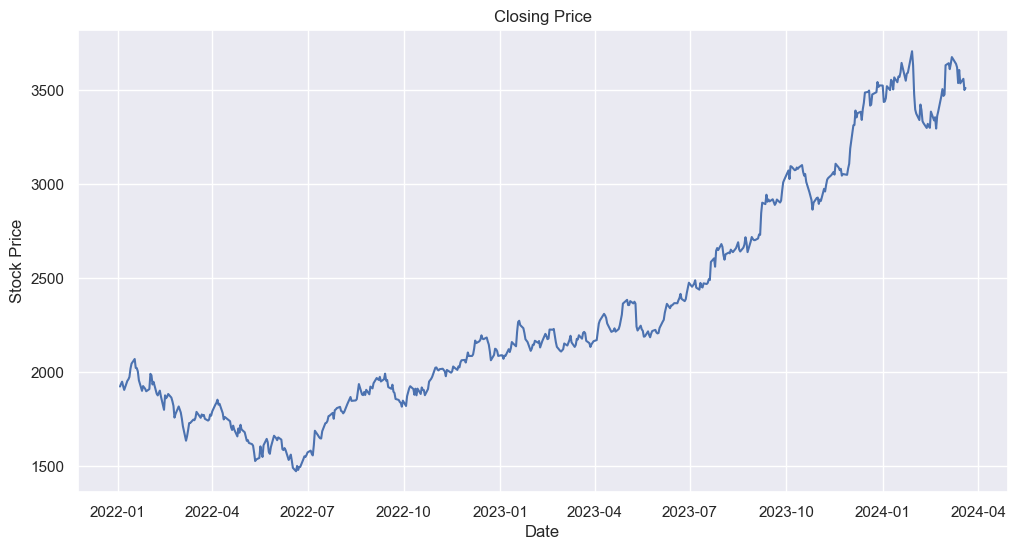

In [3]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(df['Date'], df['Close'])
plt.title('Closing Price')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.show()

In [4]:
df = pd.read_csv('LT.csv')

### Policy Gradient agent

In [19]:
import tensorflow as tf
name = 'Policy Gradient agent'
class Agent:

    LEARNING_RATE = 1e-4
    LAYER_SIZE = 256
    GAMMA = 0.9
    OUTPUT_SIZE = 3

    def __init__(self, state_size, window_size, trend, skip):
        self.state_size = state_size
        self.window_size = window_size
        self.half_window = window_size // 2
        self.trend = trend
        self.skip = skip
        self.X = tf.placeholder(tf.float32, (None, self.state_size))
        self.REWARDS = tf.placeholder(tf.float32, (None))
        self.ACTIONS = tf.placeholder(tf.int32, (None))
        feed_forward = tf.layers.dense(self.X, self.LAYER_SIZE, activation = tf.nn.relu)
        self.logits = tf.layers.dense(feed_forward, self.OUTPUT_SIZE, activation = tf.nn.softmax)
        input_y = tf.one_hot(self.ACTIONS, self.OUTPUT_SIZE)
        loglike = tf.log((input_y * (input_y - self.logits) + (1 - input_y) * (input_y + self.logits)) + 1)
        rewards = tf.tile(tf.reshape(self.REWARDS, (-1,1)), [1, self.OUTPUT_SIZE])
        self.cost = -tf.reduce_mean(loglike * (rewards + 1))
        self.optimizer = tf.train.AdamOptimizer(learning_rate = self.LEARNING_RATE).minimize(self.cost)
        self.sess = tf.InteractiveSession()
        self.sess.run(tf.global_variables_initializer())

    def predict(self, inputs):
        return self.sess.run(self.logits, feed_dict={self.X:inputs})

    def get_state(self, t):
        window_size = self.window_size + 1
        d = t - window_size + 1
        block = self.trend[d : t + 1] if d >= 0 else -d * [self.trend[0]] + self.trend[0 : t + 1]
        res = []
        for i in range(window_size - 1):
            res.append(block[i + 1] - block[i])
        return np.array([res])

    def discount_rewards(self, r):
        discounted_r = np.zeros_like(r)
        running_add = 0
        for t in reversed(range(0, r.size)):
            running_add = running_add * self.GAMMA + r[t]
            discounted_r[t] = running_add
        return discounted_r

    def get_predicted_action(self, sequence):
        prediction = self.predict(np.array(sequence))[0]
        return np.argmax(prediction)

    def buy(self, initial_money):
        starting_money = initial_money
        states_sell = []
        states_buy = []
        inventory = []
        state = self.get_state(0)
        for t in range(0, len(self.trend) - 1, self.skip):
            action = self.get_predicted_action(state)
            next_state = self.get_state(t + 1)

            if action == 1 and initial_money >= self.trend[t] and t < (len(self.trend) - self.half_window):
                inventory.append(self.trend[t])
                initial_money -= self.trend[t]
                states_buy.append(t)
                print('day %d: buy 1 unit at price %f, total balance %f'% (t, self.trend[t], initial_money))


            elif action == 2 and len(inventory):
                bought_price = inventory.pop(0)
                initial_money += self.trend[t]
                states_sell.append(t)
                try:
                    invest = ((close[t] - bought_price) / bought_price) * 100
                except:
                    invest = 0
                print(
                    'day %d, sell 1 unit at price %f, investment %f %%, total balance %f,'
                    % (t, close[t], invest, initial_money)
                )

            state = next_state
        invest = ((initial_money - starting_money) / starting_money) * 100
        total_gains = initial_money - starting_money
        return states_buy, states_sell, total_gains, invest


    def train(self, iterations, checkpoint, initial_money):
        for i in range(iterations):
            ep_history = []
            total_profit = 0
            inventory = []
            state = self.get_state(0)
            starting_money = initial_money
            for t in range(0, len(self.trend) - 1, self.skip):
                action = self.get_predicted_action(state)
                next_state = self.get_state(t + 1)
                if action == 1 and starting_money >= self.trend[t] and t < (len(self.trend) - self.half_window):
                    inventory.append(self.trend[t])
                    starting_money -= close[t]

                elif action == 2 and len(inventory):
                    bought_price = inventory.pop(0)
                    total_profit += self.trend[t] - bought_price
                    starting_money += self.trend[t]
                ep_history.append([state,action,starting_money,next_state])
                state = next_state
            ep_history = np.array(ep_history)
            ep_history[:,2] = self.discount_rewards(ep_history[:,2])
            cost, _ = self.sess.run([self.cost, self.optimizer], feed_dict={self.X:np.vstack(ep_history[:,0]),
                                                    self.REWARDS:ep_history[:,2],
                                                    self.ACTIONS:ep_history[:,1]})
            if (i+1) % checkpoint == 0:
                print('epoch: %d, total rewards: %f.3, cost: %f, total money: %f'%(i + 1, total_profit, cost,
                                                                                  starting_money))

In [20]:
close = df.Close.values.tolist()
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
initial_money = 10000
window_size = 30
skip = 1
agent = Agent(state_size = window_size,
             window_size = window_size,
             trend = close,
             skip = skip)
agent.train(iterations = 500, checkpoint = 25, initial_money = initial_money)

C:\Users\soham\AppData\Local\Temp\ipykernel_16212\1227321769.py:19: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  feed_forward = tf.layers.dense(self.X, self.LAYER_SIZE, activation = tf.nn.relu)
C:\Users\soham\AppData\Local\Temp\ipykernel_16212\1227321769.py:20: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  self.logits = tf.layers.dense(feed_forward, self.OUTPUT_SIZE, activation = tf.nn.softmax)
C:\Users\soham\AppData\Local\Temp\ipykernel_16212\1227321769.py:109: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ep_history = np.array(ep_history)


epoch: 25, total rewards: 1845.351196.3, cost: -3795.302490, total money: 11845.351196
epoch: 50, total rewards: 1708.750366.3, cost: -4091.716064, total money: 11708.750366
epoch: 75, total rewards: 1829.450684.3, cost: -4078.428467, total money: 11829.450684
epoch: 100, total rewards: 2160.650269.3, cost: -5032.188477, total money: 12160.650269
epoch: 125, total rewards: 1470.300293.3, cost: -5666.811035, total money: 11470.300293
epoch: 150, total rewards: 1675.650513.3, cost: -4607.769531, total money: 11675.650513
epoch: 175, total rewards: 1711.801025.3, cost: -6560.105957, total money: 11711.801025
epoch: 200, total rewards: 1211.250610.3, cost: -4917.989258, total money: 11211.250610
epoch: 225, total rewards: 1575.150269.3, cost: -6409.253906, total money: 11575.150269
epoch: 250, total rewards: 1876.800171.3, cost: -4557.397949, total money: 11876.800171
epoch: 275, total rewards: 1964.850586.3, cost: -7278.985352, total money: 11964.850586
epoch: 300, total rewards: 1902.100

In [24]:
states_buy, states_sell, total_gains, invest = agent.buy(initial_money = initial_money)

day 1: buy 1 unit at price 1937.550049, total balance 8062.449951
day 2: buy 1 unit at price 1948.599976, total balance 6113.849976
day 3, sell 1 unit at price 1924.500000, investment -0.673534 %, total balance 8038.349976,
day 5: buy 1 unit at price 1953.099976, total balance 6085.250000
day 6: buy 1 unit at price 1961.150024, total balance 4124.099976
day 8, sell 1 unit at price 2018.400024, investment 3.582061 %, total balance 6142.500000,
day 9: buy 1 unit at price 2044.750000, total balance 4097.750000
day 10, sell 1 unit at price 2069.399902, investment 5.954633 %, total balance 6167.149902,
day 11, sell 1 unit at price 2022.199951, investment 3.112966 %, total balance 8189.349854,
day 15: buy 1 unit at price 1899.900024, total balance 6289.449829
day 17: buy 1 unit at price 1910.849976, total balance 4378.599854
day 18, sell 1 unit at price 1897.550049, investment -7.198922 %, total balance 6276.149902,
day 20: buy 1 unit at price 1990.500000, total balance 4285.649902
day 21, s

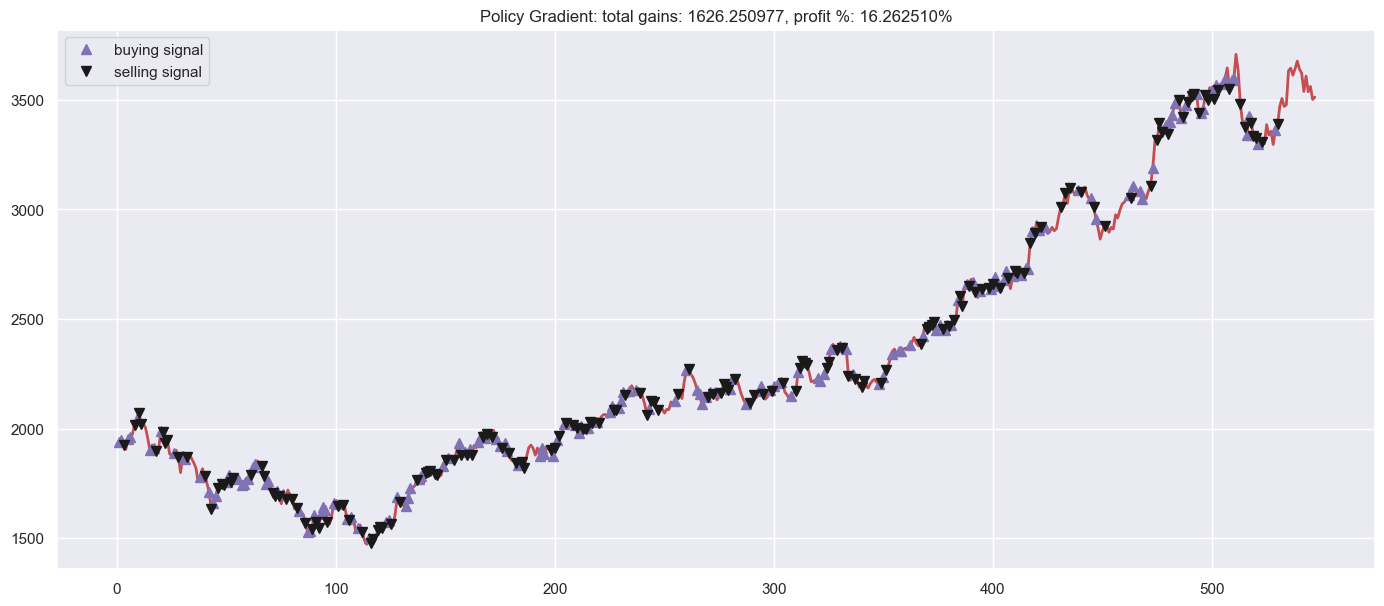

In [25]:
fig = plt.figure(figsize = (17,7))
plt.plot(close, color='r', lw=2.)
plt.plot(close, '^', markersize=7, color='m', label = 'buying signal', markevery = states_buy)
plt.plot(close, 'v', markersize=7, color='k', label = 'selling signal', markevery = states_sell)
plt.title('Policy Gradient: total gains: %f, profit %%: %f%%'%(total_gains, invest))
plt.legend()
plt.show()

In [23]:
# Calculate performance metrics
def calculate_metrics(states_buy, states_sell, close_prices, initial_money):
    total_gains = close_prices[-1] - close_prices[0]
    ROI = ((close_prices[-1] - close_prices[0]) / close_prices[0]) * 100

    # Calculate Sharpe Ratio (assuming risk-free rate is 0)
    returns = np.diff(close_prices) / close_prices[:-1]
    sharpe_ratio = np.sqrt(252) * np.mean(returns) / np.std(returns)

    # Calculate maximum drawdown
    max_drawdown = np.max(np.maximum.accumulate(close_prices) - close_prices) / np.max(np.maximum.accumulate(close_prices))

    # Calculate winning trades percentage
    winning_trades = len(states_sell) / (len(states_buy) + len(states_sell)) * 100

    # Calculate average return per trade
    avg_return_per_trade = total_gains / (len(states_buy) + len(states_sell))

    # Calculate average holding period
    holding_periods = [sell - buy for buy, sell in zip(states_buy, states_sell)]
    avg_holding_period = np.mean(holding_periods)

    # Other metrics such as risk of ruin, Calmar ratio, and Sortino ratio can be calculated as needed

    return total_gains, ROI, sharpe_ratio, max_drawdown, winning_trades, avg_return_per_trade, avg_holding_period

# Simulate trading and compute performance metrics
initial_money = 10000
close_prices = df['Close'].values
total_gains, ROI, sharpe_ratio, max_drawdown, winning_trades, avg_return_per_trade, avg_holding_period = calculate_metrics(
    states_buy, states_sell, close_prices, initial_money)

# Print performance metrics
print("Performance Metrics:")
print("Total Gains: {:.2f}".format(total_gains))
print("Return on Investment (ROI): {:.2f}%".format(ROI))
print("Sharpe Ratio: {:.2f}".format(sharpe_ratio))
print("Maximum Drawdown: {:.2f}%".format(max_drawdown * 100))
print("Winning Trades Percentage: {:.2f}%".format(winning_trades))
print("Average Return per Trade: {:.2f}".format(avg_return_per_trade))
print("Average Holding Period: {:.2f}".format(avg_holding_period))


Performance Metrics:
Total Gains: 1589.60
Return on Investment (ROI): 82.67%
Sharpe Ratio: 1.33
Maximum Drawdown: 16.12%
Winning Trades Percentage: 50.00%
Average Return per Trade: 4.91
Average Holding Period: 5.55
